# New libraries to install

In [ ]:
!pip install transformers[sentencepiece]==4.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Connection to drive and path definition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/final/SANDS')
path_files ='/content/drive/MyDrive/Colab Notebooks/final/UC7'

# Import libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import time
from calendar import timegm, monthrange
from datetime import datetime, timedelta
import math
import sands
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from os import listdir
from os.path import isfile, join
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy,Accuracy,BinaryAccuracy


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing
from scipy.stats import iqr


import json

import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from transformers import pipeline



# Data generation or load

In [ ]:
parameters1 = {
        'time_delta':5
    }

In [ ]:
device_filter = {
    'vendor':'Juniper',
    'role': 'PE'
}

In [ ]:
events_df = sands.generate_events_time_range(datetime.strptime('10/01/22 00:00:01', '%m/%d/%y %H:%M:%S'),datetime.strptime('10/01/22 00:00:01', '%m/%d/%y %H:%M:%S')+timedelta(hours=1),parameters1,"all",with_incidents=True)




In [ ]:
events_df.to_csv(join(path_files,'log_classification.csv'))

In [ ]:
events_df=pd.read_csv(join(path_files,'log_classification.csv'),index_col=0)

In [ ]:
events_df

,timestamp,event_name,source,fields,severity,message
0,1664582401,high_temperature_log,C-1,"[{""device_name"": ""C-1"", ""ip_address"": ""10.2.1....",warning,2022-10-01 00:00:01: shelf_mgr[5371]: %INFRA-S...
426,1664582401,interface_down,tun-1-1-13-2,"[{""device_name"": ""E-1-1"", ""interface_name"": ""t...",error,2022-10-01 00:00:01: if_mgr[7358]: %INTF-STATE...
427,1664582401,interface_down,tun-1-1-26-1,"[{""device_name"": ""E-1-1"", ""interface_name"": ""t...",error,2022-10-01 00:00:01: if_mgr[6436]: %INTF-STATE...
428,1664582401,interface_local_fault,tun-1-1-30-2,"[{""device_name"": ""E-1-1"", ""interface_name"": ""t...",critical,2022-10-01 00:00:01: npu_drvr[5440]: %PLATFORM...
429,1664582401,interface_up,tun-1-1-33-1,"[{""device_name"": ""E-1-1"", ""interface_name"": ""t...",info,2022-10-01 00:00:01: if_mgr[342]: %INTF-STATE_...
...,...,...,...,...,...,...
8071,1664585941,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 00:59:01: bgp_mgr[5211]: %BGP-STATE...
8072,1664585941,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 00:59:01: bgp_mgr[8874]: %BGP-STATE...
8073,1664585941,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""11...",info,2022-10-01 00:59:01: bgp_mgr[9872]: %BGP-STATE...
8075,1664585941,bgp_session_up,PE-10,"[{""device_name"": ""PE-10"", ""local_address"": ""12...",info,2022-10-01 00:59:01: bgp_mgr[9888]: %BGP-STATE...


# Data preparation

In [ ]:
log_df = events_df[['message','severity']].copy()

In [ ]:
log_df

,message,severity
0,2022-10-01 00:00:01: shelf_mgr[5371]: %INFRA-S...,warning
426,2022-10-01 00:00:01: if_mgr[7358]: %INTF-STATE...,error
427,2022-10-01 00:00:01: if_mgr[6436]: %INTF-STATE...,error
428,2022-10-01 00:00:01: npu_drvr[5440]: %PLATFORM...,critical
429,2022-10-01 00:00:01: if_mgr[342]: %INTF-STATE_...,info
...,...,...
8071,2022-10-01 00:59:01: bgp_mgr[5211]: %BGP-STATE...,info
8072,2022-10-01 00:59:01: bgp_mgr[8874]: %BGP-STATE...,info
8073,2022-10-01 00:59:01: bgp_mgr[9872]: %BGP-STATE...,info
8075,2022-10-01 00:59:01: bgp_mgr[9888]: %BGP-STATE...,info


In [ ]:
log_mask=np.logical_not(log_df['message'].isna())

In [ ]:
log_df = log_df[log_mask].copy()

In [ ]:
log_list = log_df['message'].to_list()

In [ ]:
log_list

["2022-10-01 00:00:01: shelf_mgr[5371]: %INFRA-SHELF_MGR-3-HW_HIGH_TEMP : HW warning event HW_EVENT_FAILURE, event_reason_str 'High Temperature' for device C-1 with hw revision hw3959392",
 '2022-10-01 00:00:01: if_mgr[7358]: %INTF-STATE_MGR-3-STATE_CHANGE_EVENT : Interface changed state to down: tun-13-2 in device E-1-1',
 '2022-10-01 00:00:01: if_mgr[6436]: %INTF-STATE_MGR-3-STATE_CHANGE_EVENT : Interface changed state to down: tun-26-1 in device E-1-1',
 '2022-10-01 00:00:01: npu_drvr[5440]: %PLATFORM-VETH_PD-2-RX_FAULT : Interface tun-30-2, Detected Local Fault',
 '2022-10-01 00:00:01: if_mgr[342]: %INTF-STATE_MGR-3-STATE_CHANGE_EVENT : Interface changed state to up: tun-33-1 in device E-1-1',
 '2022-10-01 00:00:01: bgp_mgr[2136]: %BGP-STATE_MGR-3-STATE_CHANGE_EVENT : BGP session to 1.1.33.22/30 changed state to down in device E-1-1',
 '2022-10-01 00:00:01: if_mgr[4144]: %INTF-STATE_MGR-3-STATE_CHANGE_EVENT : Interface changed state to down: tun-49-1 in device E-1-1',
 '2022-10-01 

In [ ]:
string.punctuation


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
clean_log_list = []
for log_message in log_list:
  for char in string.punctuation:
    log_message = log_message.replace(char,' ')
  clean_log_list.append(re.sub(r'[0-9]','',log_message))


In [ ]:
clean_log_list

['       shelf mgr     INFRA SHELF MGR  HW HIGH TEMP   HW warning event HW EVENT FAILURE  event reason str  High Temperature  for device C  with hw revision hw',
 '       if mgr     INTF STATE MGR  STATE CHANGE EVENT   Interface changed state to down  tun   in device E  ',
 '       if mgr     INTF STATE MGR  STATE CHANGE EVENT   Interface changed state to down  tun   in device E  ',
 '       npu drvr     PLATFORM VETH PD  RX FAULT   Interface tun    Detected Local Fault',
 '       if mgr     INTF STATE MGR  STATE CHANGE EVENT   Interface changed state to up  tun   in device E  ',
 '       bgp mgr     BGP STATE MGR  STATE CHANGE EVENT   BGP session to      changed state to down in device E  ',
 '       if mgr     INTF STATE MGR  STATE CHANGE EVENT   Interface changed state to down  tun   in device E  ',
 '       if mgr     INTF STATE MGR  STATE CHANGE EVENT   Interface changed state to down  tun   in device E  ',
 '       if mgr     INTF STATE MGR  STATE CHANGE EVENT   Interface changed

In [ ]:
coun_vect = CountVectorizer()
count_matrix = coun_vect.fit_transform(clean_log_list)
count_array = count_matrix.toarray()
df1 = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names_out())
print(df1)

      alarm  authen  authenticated  authentication  bgp  by  change  changed  \
0         0       0              0               0    0   0       0        0   
1         0       0              0               0    0   0       1        1   
2         0       0              0               0    0   0       1        1   
3         0       0              0               0    0   0       0        0   
4         0       0              0               0    0   0       1        1   
...     ...     ...            ...             ...  ...  ..     ...      ...   
7890      0       0              0               0    3   0       1        1   
7891      0       0              0               0    3   0       1        1   
7892      0       0              0               0    3   0       1        1   
7893      0       0              0               0    3   0       1        1   
7894      0       0              0               0    3   0       1        1   

      changes  clear  ...  uid  up  use

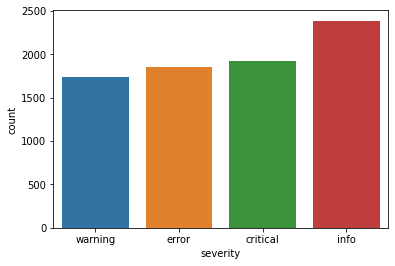

In [ ]:
sns.countplot(x=log_df["severity"])

In [ ]:
print(coun_vect.vocabulary_)

{'shelf': 81, 'mgr': 56, 'infra': 42, 'hw': 38, 'high': 37, 'temp': 89, 'warning': 102, 'event': 25, 'failure': 30, 'reason': 73, 'str': 85, 'temperature': 90, 'for': 34, 'device': 20, 'with': 103, 'revision': 76, 'if': 39, 'intf': 46, 'state': 84, 'change': 6, 'interface': 45, 'changed': 7, 'to': 92, 'down': 21, 'tun': 93, 'in': 40, 'npu': 58, 'drvr': 22, 'platform': 69, 'veth': 99, 'pd': 66, 'rx': 77, 'fault': 32, 'detected': 19, 'local': 50, 'up': 95, 'bgp': 4, 'session': 80, 'lda': 48, 'server': 79, 'pkt': 68, 'fm': 33, 'major': 54, 'alarm': 0, 'optics': 60, 'power': 71, 'lane': 47, 'clear': 9, 'et': 24, 'pe': 67, 'no': 57, 'input': 43, 'or': 61, 'sshd': 83, 'security': 78, 'info': 41, 'user': 97, 'logout': 53, 'uid': 94, 'from': 35, 'logged': 51, 'out': 62, 'on': 59, 'vty': 101, 'envmon': 23, 'system': 88, 'fan': 31, 'failed': 29, 'critical': 16, 'has': 36, 'please': 70, 'replace': 74, 'the': 91, 'prevent': 72, 'overheating': 64, 'versa': 98, 'exec': 27, 'login': 52, 'authen': 1, 

In [ ]:
X = count_array
y = log_df['severity'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

# Random Forest Classifier

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)


RandomForestClassifier()

In [ ]:
y_test_pred = rf_model.predict(X_test)

In [ ]:
y_test_pred

array(['error', 'error', 'error', ..., 'warning', 'info', 'warning'],
      dtype=object)

In [ ]:
log_df['severity'].unique()

array(['warning', 'error', 'critical', 'info'], dtype=object)

In [ ]:
print(classification_report(y_test, y_test_pred, target_names=log_df['severity'].unique()))

              precision    recall  f1-score   support

     warning       1.00      1.00      1.00       638
       error       1.00      1.00      1.00       616
    critical       1.00      1.00      1.00       815
        info       1.00      1.00      1.00       537

    accuracy                           1.00      2606
   macro avg       1.00      1.00      1.00      2606
weighted avg       1.00      1.00      1.00      2606



In [ ]:
log_df

,message,severity
0,2022-10-01 00:00:01: shelf_mgr[5371]: %INFRA-S...,warning
426,2022-10-01 00:00:01: if_mgr[7358]: %INTF-STATE...,error
427,2022-10-01 00:00:01: if_mgr[6436]: %INTF-STATE...,error
428,2022-10-01 00:00:01: npu_drvr[5440]: %PLATFORM...,critical
429,2022-10-01 00:00:01: if_mgr[342]: %INTF-STATE_...,info
...,...,...
8071,2022-10-01 00:59:01: bgp_mgr[5211]: %BGP-STATE...,info
8072,2022-10-01 00:59:01: bgp_mgr[8874]: %BGP-STATE...,info
8073,2022-10-01 00:59:01: bgp_mgr[9872]: %BGP-STATE...,info
8075,2022-10-01 00:59:01: bgp_mgr[9888]: %BGP-STATE...,info


In [ ]:
log_df.loc[428,'message']

'2022-10-01 00:00:01: npu_drvr[5440]: %PLATFORM-VETH_PD-2-RX_FAULT : Interface tun-30-2, Detected Local Fault'

In [ ]:
test_log = ['2022-10-01 00:00:01: npu_driver[5440]: %PLATFORM-VETH_PD-2-TX_FAULT : Interface E-30-2, Detected Remote Fault']

In [ ]:
clean_test_log_list = []
for log_message in test_log:
  for char in string.punctuation:
    log_message = log_message.replace(char,' ')
  clean_test_log_list.append(re.sub(r'[0-9]','',log_message))

In [ ]:
count_matrix_test_log = coun_vect.transform(clean_test_log_list)
count_array_test_log = count_matrix_test_log.toarray()

In [ ]:
y_log_test_pred = rf_model.predict(count_array_test_log)

In [ ]:
y_log_test_pred

array(['critical'], dtype=object)

# Multiple algorithm cross validation

In [ ]:
models = [
    LinearSVC(),#Linear Support Vector Classification.
    MultinomialNB(),#Naive Bayes classifier for multinomial models
    LogisticRegression(random_state=0),
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

In [ ]:
cv_df

,model_name,fold_idx,accuracy
0,LinearSVC,0,1.000000
1,LinearSVC,1,1.000000
2,LinearSVC,2,1.000000
3,LinearSVC,3,1.000000
4,LinearSVC,4,1.000000
5,LinearSVC,5,1.000000
6,LinearSVC,6,1.000000
7,LinearSVC,7,1.000000
8,LinearSVC,8,1.000000
9,LinearSVC,9,1.000000


In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC             1.000000
LogisticRegression    1.000000
MultinomialNB         0.866501
Name: accuracy, dtype: float64

# Zero shot classification

In [ ]:
classifier = pipeline("zero-shot-classification", 
                      model="facebook/bart-large-mnli")
                      #model="vicgalle/xlm-roberta-large-xnli-anli")

In [ ]:

def plot_results(result):
    scores = result["scores"]
    plt.figure(dpi=150)
    plt.bar(output["labels"], scores)
    plt.xlabel("Labels to classify")
    plt.ylabel("Probability of the label")
    plt.title(result["sequence"])
    n = list(range(len(scores)))
    for i in n:
        plt.annotate(f"{100*scores[i]:.1f}%", xy=(n[i],scores[i]*.8), ha='center', va='bottom')

    plt.show()

In [ ]:
sequence = "Can kubernetes cluster restore automatically against failures?"
labels = ['cloud', 'network', 'microservices']
output = classifier(sequence, labels)
output

{'sequence': 'Can kubernetes cluster restore automatically against failures?',
 'labels': ['network', 'cloud', 'microservices'],
 'scores': [0.8080534934997559, 0.1345714032649994, 0.05737515911459923]}

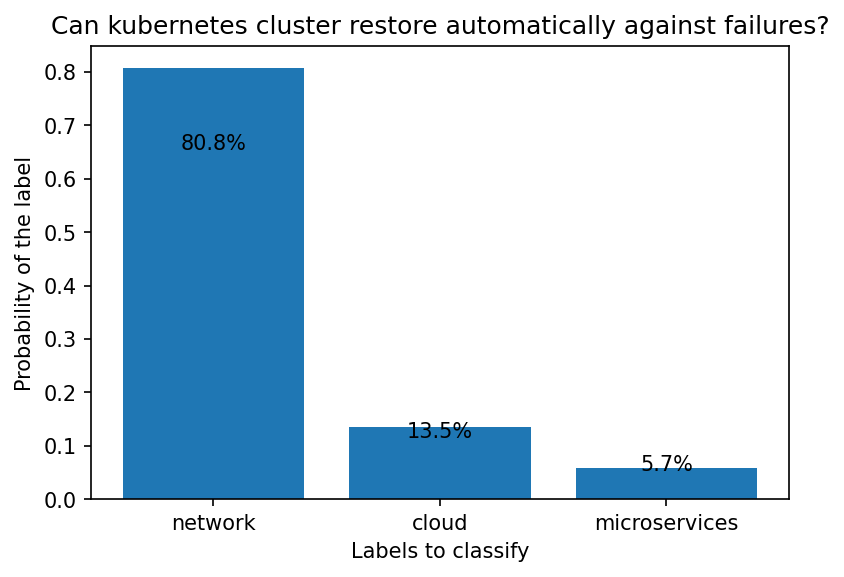

In [ ]:
plot_results(output)

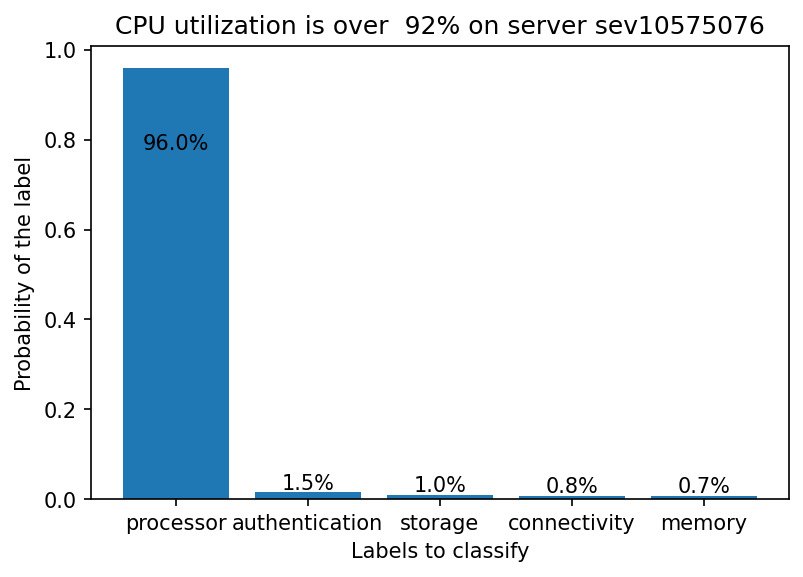

In [ ]:
sequence = "CPU utilization is over  92% on server sev10575076"
labels = "processor memory storage connectivity authentication".split()
output = classifier(sequence, labels)
plot_results(output)

In [ ]:
log_df.iloc[18,:]

message     2022-10-01 00:00:01: bgp_mgr[373]: %BGP-STATE_...
severity                                             critical
Name: 442, dtype: object

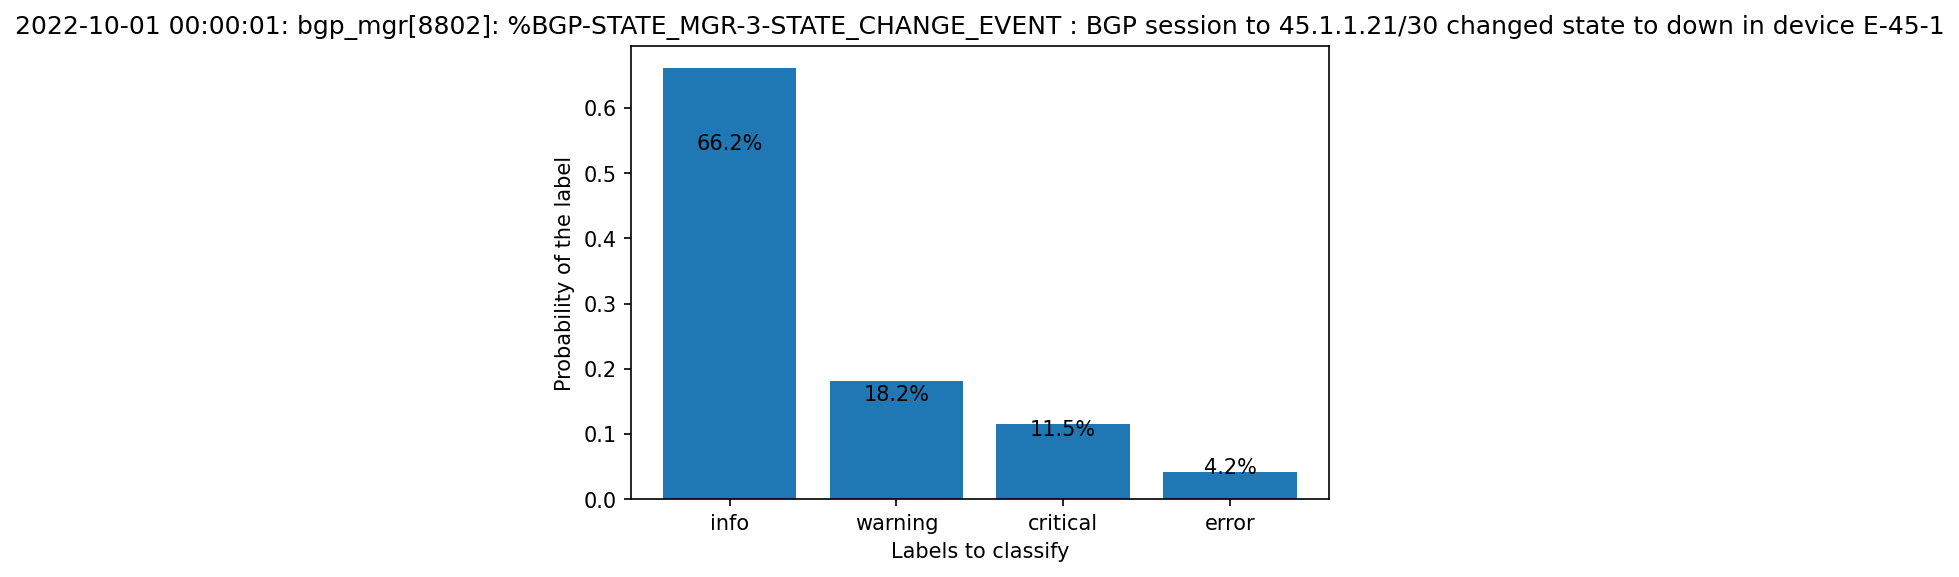

In [ ]:
log_message = "2022-10-01 00:00:01: bgp_mgr[8802]: %BGP-STATE_MGR-3-STATE_CHANGE_EVENT : BGP session to 45.1.1.21/30 changed state to down in device E-45-1"
labels = ["critical","error","warning","info"]
output = classifier(log_message, labels)
plot_results(output)

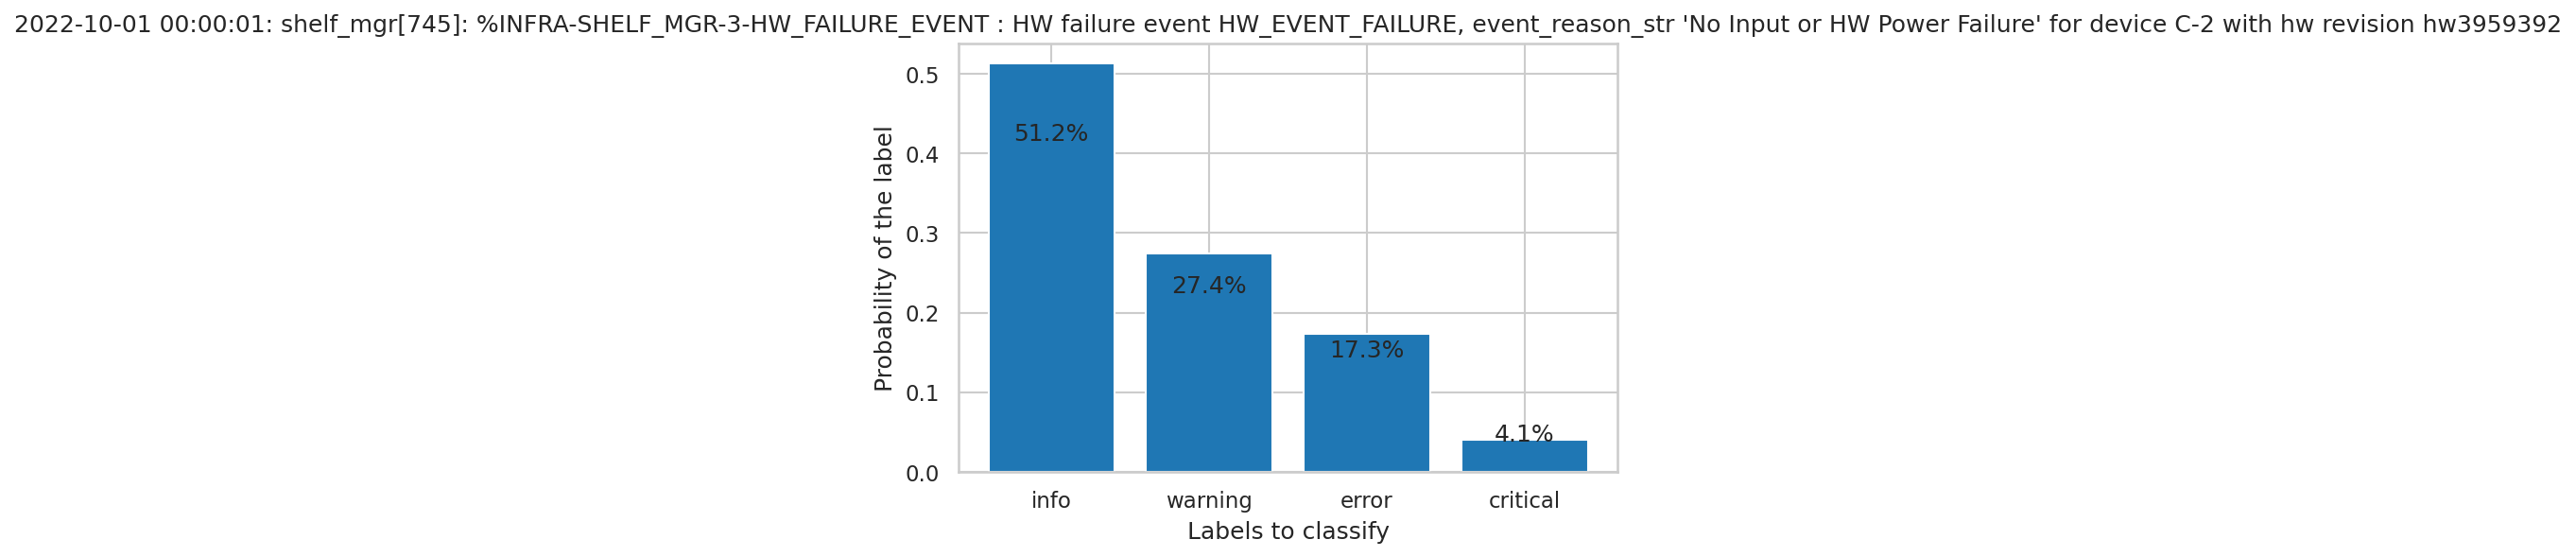

In [ ]:
log_message = "2022-10-01 00:00:01: shelf_mgr[745]: %INFRA-SHELF_MGR-3-HW_FAILURE_EVENT : HW failure event HW_EVENT_FAILURE, event_reason_str 'No Input or HW Power Failure' for device C-2 with hw revision hw3959392"
labels = ["critical","error","warning","info"]
output = classifier(log_message, labels)
plot_results(output)

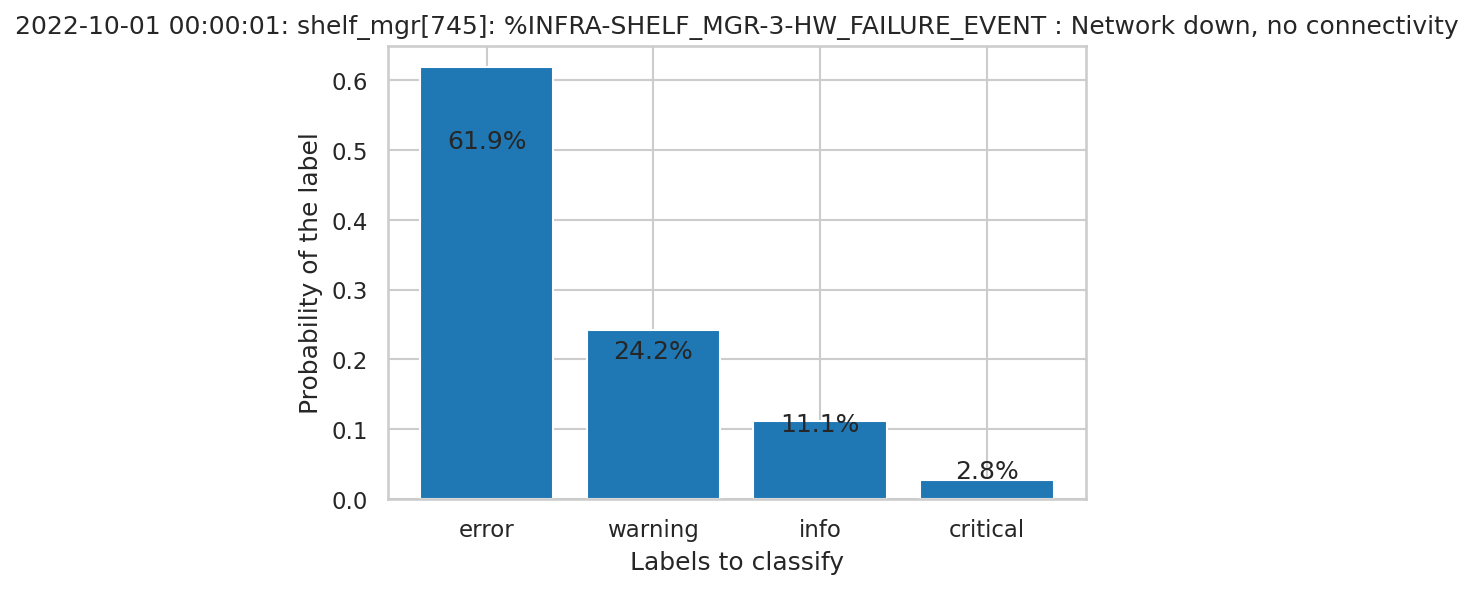

In [ ]:
log_message = "2022-10-01 00:00:01: shelf_mgr[745]: %INFRA-SHELF_MGR-3-HW_FAILURE_EVENT : Network down, no connectivity"
labels = ["critical","error","warning","info"]
output = classifier(log_message, labels)
plot_results(output)

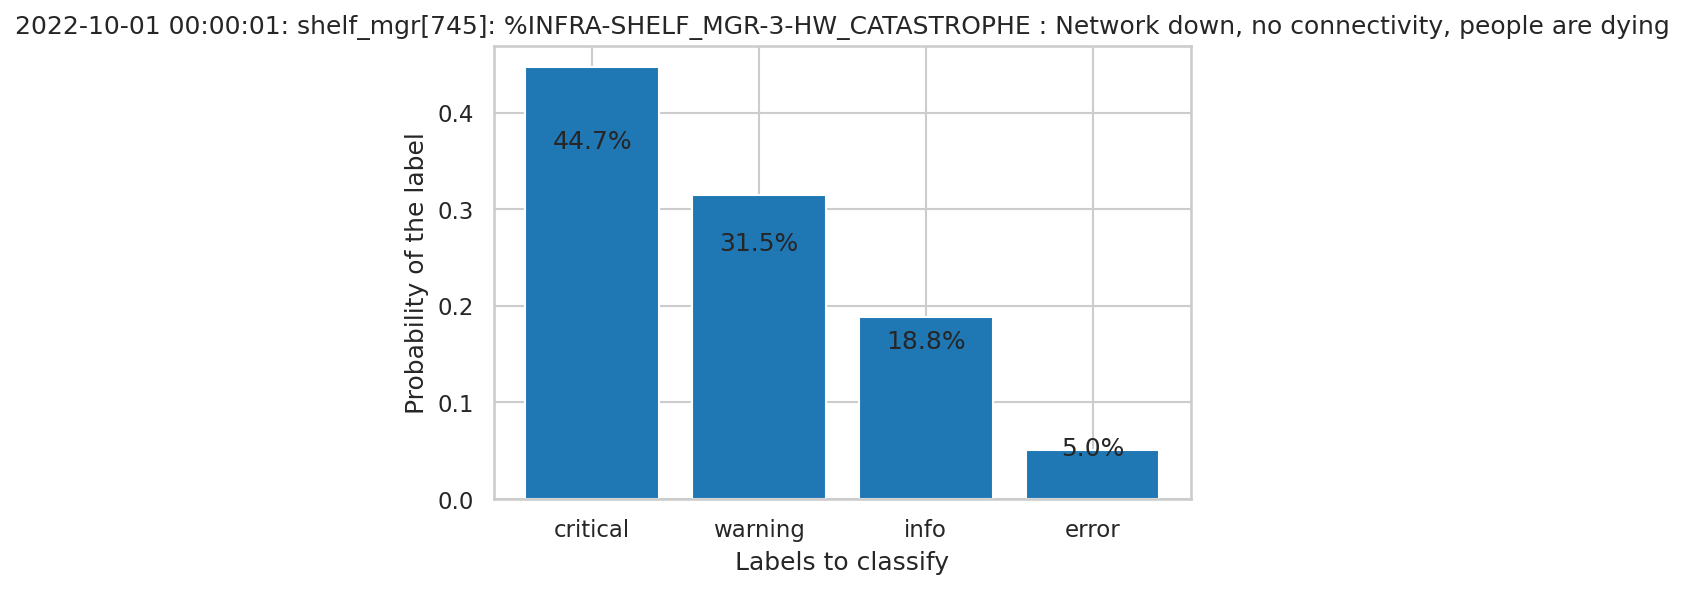

In [ ]:
log_message = "2022-10-01 00:00:01: shelf_mgr[745]: %INFRA-SHELF_MGR-3-HW_CATASTROPHE : Network down, no connectivity, people are dying"
labels = ["critical","error","warning","info"]
output = classifier(log_message, labels)
plot_results(output)

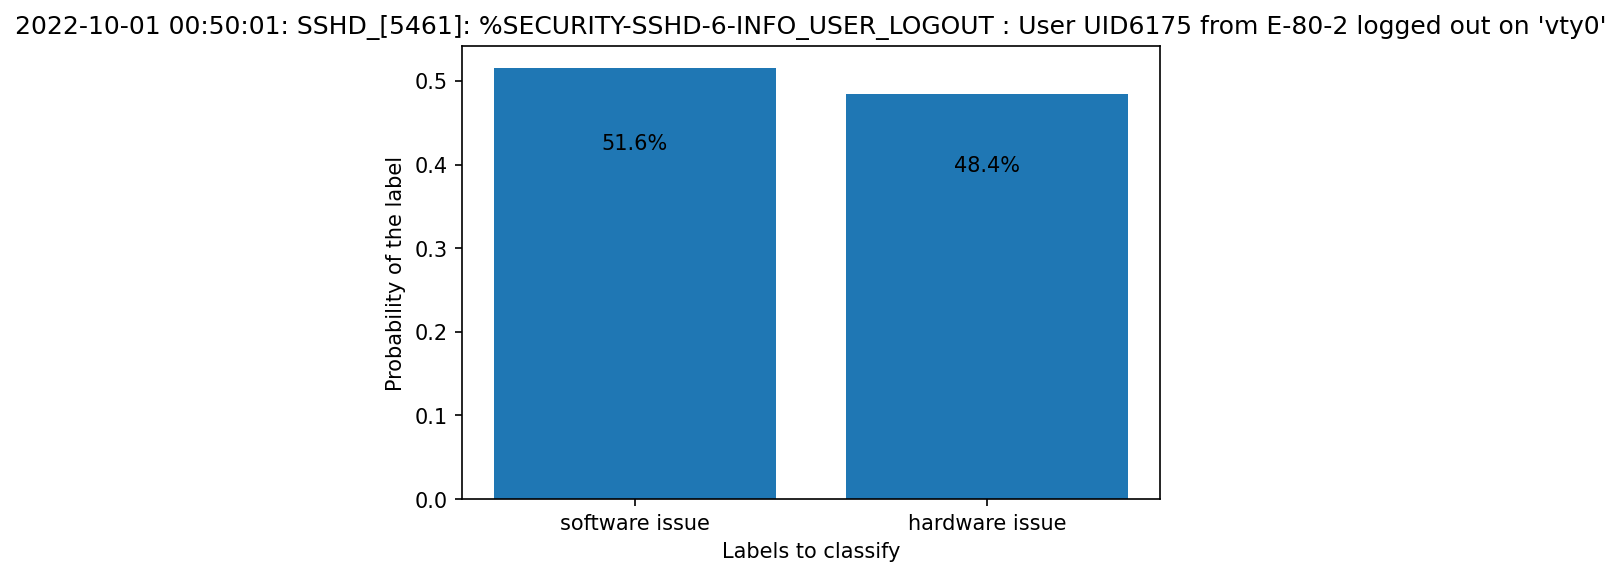

In [ ]:
log_message = "2022-10-01 00:50:01: SSHD_[5461]: %SECURITY-SSHD-6-INFO_USER_LOGOUT : User UID6175 from E-80-2 logged out on 'vty0'"
labels = ["software issue","hardware issue"]
output = classifier(log_message, labels)
plot_results(output)

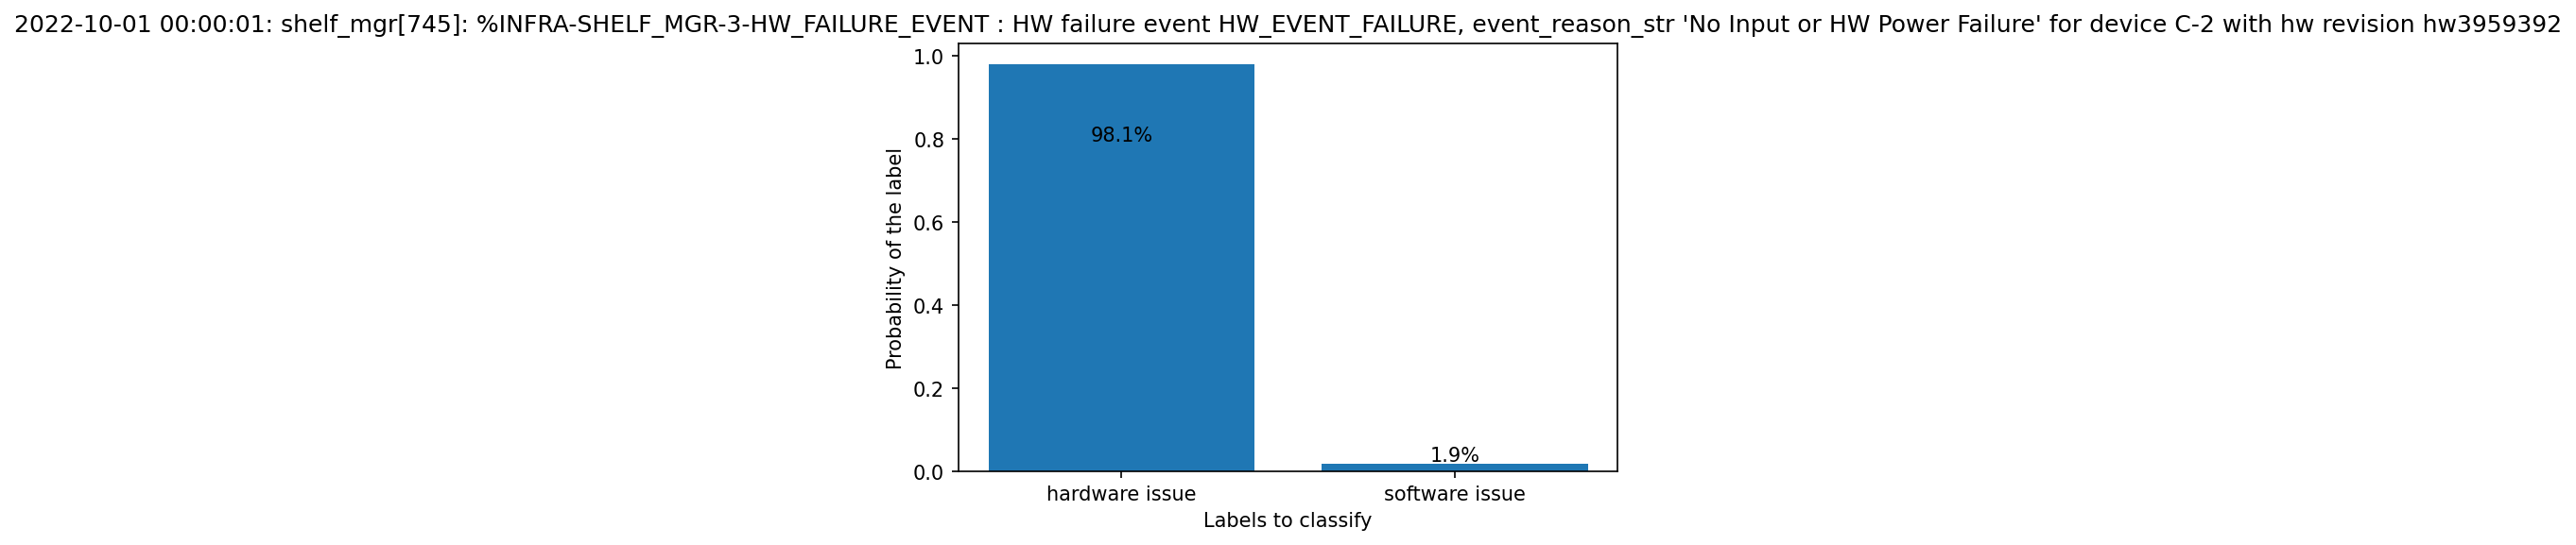

In [ ]:
log_message = "2022-10-01 00:00:01: shelf_mgr[745]: %INFRA-SHELF_MGR-3-HW_FAILURE_EVENT : HW failure event HW_EVENT_FAILURE, event_reason_str 'No Input or HW Power Failure' for device C-2 with hw revision hw3959392"
labels = ["software issue","hardware issue"]
output = classifier(log_message, labels)
plot_results(output)